In [41]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
#from collections import OrderedDict
import scipy.optimize 
#import mpl_toolkits.axisartist as axisartist
import os
import math
import cmath
import scipy.optimize as opt
import random
#import operator
#import copy
#import sys
import scipy.integrate as integrate
from scipy.stats import multivariate_normal

%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)
mpl.rc('font',family='Times New Roman')

## Gaussian discriminant analysis + comparison with logistic regression and simple perceptron

Assume we have some Gaussian distributions ($x_s$ describe features, while $y$ represents the class of objects)

$$
p(x_s|y_j)=\frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}}\mathrm{exp}\left(-\frac{1}{2}(x_s-\mu_j)^T\Sigma^{-1}(x_s-\mu_j)\right),
$$

where $\mu_{j}, \Sigma, \phi$ are parameters to determine. In the binary case $p(y)=\phi^y(1-\phi)^{1-y}$ (Bernoulli distribution) $\Longrightarrow y$ can be either $0$ or $1$. Thus we have two mean values $\mu_0$ and $\mu_1$ to determine (in general we can have $M$ different classes for which the features can be distributed in a Gaussian-like way centered at $M$ different $\mu$'s).

In order to attack the problem we need to have a training set $\{x^{(i)},y^{(i)}\}$ containing of $M$ elements. For the purpose of the analysis we generate such a set by hand assuming that the features are distributed according to Gausssian disribution. 

Let us assume that we have 2 features describing our objects belonging to 2 classes ($y=0$ and $y=1$). These features can be represented by real numbers so that $x^{(i)}=\{x_1^{(i)}, x_2^{(i)}\}$, where $x_{s=1,2}^{(i=1,2,\ldots,M)}\in\mathbb{R}$. Let us define gaussian function with some $\Sigma$ (given by hand; the dimension of $\Sigma$ matrix is given by the number of features describing objects $\longrightarrow$ in our case we have 2 features so $\Sigma$ is a $2\times2$ matrix), and with some mean $\mu$. Thanks to the fact we know the distributions from the very beginning we can check if our procedure works well, i.e if the determined $\Sigma$ and $\mu$'s are close to the assumed ones.


Now I generate the data for two different cases. For this purpose I use implemented function for a random choice of numbers according to the "multivariate_normal" distribution.

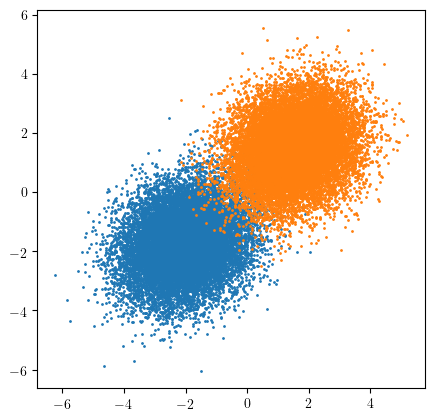

In [42]:
# Set the parameters for two classes y0=0, y1=1 (variables are indexed by 0 and 1 respectively)
mu0 = np.array([-2,-1.7]) # mean for class 0
mu1 = np.array([1.5,1.5])   # mean for class 1
Sigma0=np.array([[1,0.2],[0.2,1]]) # cov matrix for class 0 
Sigma1=np.array([[1,0.2],[0.2,1]]) # cov matrix for class 1 

# Generate num0 and num1 random values of features for these two classes
num0=16450
num1=17367
X0s = np.random.multivariate_normal(mu0, Sigma0, num0)
X1s = np.random.multivariate_normal(mu1, Sigma1, num1)

# and create corresponding lists of classes
Y0=np.empty(num0)
Y1=np.empty(num1)
Y0.fill(0) # vector of length num filled with 0's
Y1.fill(1) # vector of length num filled with 1's

# prepare data and plot
X0_1s = np.transpose(X0s)[0]
X0_2s = np.transpose(X0s)[1]
X1_1s = np.transpose(X1s)[0]
X1_2s = np.transpose(X1s)[1]

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X0_1s,X0_2s,s=1)
plt.scatter(X1_1s,X1_2s,s=1)

Next we want to minimize Joint Likelihood:

$
L(\phi,\mu_0,\mu_2,\Sigma)=\prod_{j=1}^M P(x^{(j)},y^{(j)},\phi,\mu_0,\mu_1,\Sigma)
\equiv\prod_{j=1}^M p(x^{(j)}|y^{(j)}) p(y^{j}),
$

where the information about $\mu_0,\mu_1,\Sigma$ and $\phi$ is hidden in $p(x^{(j)}|y^{(j)})$ and $p(y^{j})$, respectively. $L$ is a cost function of $x$ and $y$. To minimize it we consider $l=log(L)$ and calculate derivatives with respect to the parameters. In minimum all the derivatives should be $= 0$, which corresponds to 

$
\phi=\frac{1}{M}\sum_{j=1}^M y^{(j)}=\frac{1}{M}\sum_{j=1}^M 1\{y^{(j)}=1\}, 
\quad 
\mu_{0}=\frac{ \sum_{j=1}^M 1\{y^{(j)}=0\}x^{(j)}   }{  \sum_{j=1}^M 1\{y^{(j)}=0\} },
\quad 
\mu_{1}=\frac{ \sum_{j=1}^M 1\{y^{(j)}=1\}x^{(j)}   }{  \sum_{j=1}^M 1\{y^{(j)}=1\} },
\quad
\Sigma=\frac{1}{M}\sum_{j=1}^M(x^{(j)}-\mu_{y^{(j)}})(x^{(j)}-\mu_{y^{(j)}})^T
$

Let us implement them and check if the results coincide with those we have chosen to generate the data.

But... first we of course should mix the data somehow as now they are clearly separated ;)

In [43]:
# We merge datasets and shuffle them - in the same way for x an y
X=np.concatenate((X0s,X1s))
Y=np.concatenate((Y0,Y1))

indices = np.arange(X.shape[0]) # prepare indices to shuffle
np.random.shuffle(indices)      # shuffle indices

Xshuffled = X[indices] # shuffle array according to shuffled indices
Yshuffled = Y[indices] # shuffle array according to shuffled indices

# Calculate parameters
M = len(X)

# Phi
Phi = 1./M *np.sum(Yshuffled) 

# mu0 and mu1
Mu0 = np.array([0.,0.])
Mu1 = np.array([0.,0.])
NumInClass0 = 0;
NumInClass1 = 0;
for i in range (0, M):
    if Yshuffled[i] < 1:
        Mu0 = np.add(Mu0, Xshuffled[i])
        NumInClass0 += 1
    else:
        Mu1 = np.add(Mu1, Xshuffled[i])
        NumInClass1 += 1

Mu0 = Mu0/NumInClass0
Mu1 = Mu1/NumInClass1

# Covariance matrix Sigma
Sigm = np.zeros((2,2))
for i in range (0, M):
    TmpVec = np.zeros((2,2))
    if Yshuffled[i] < 1:
        TmpVec = np.add(Xshuffled[i], -1.*Mu0)
    else:
        TmpVec = np.add(Xshuffled[i], -1.*Mu1)
    TmpMat = np.outer(TmpVec,TmpVec)/M
    Sigm = np.add(Sigm, TmpMat)
    
        
print( "Phi = " +str(Phi) )  
print( "Mu0 = " +str(Mu0) +" while previously chosen mu0 = " +str(mu0) )
print( "Mu1 = " +str(Mu1) +" while previously chosen mu1 = " +str(mu1) )   
print( "Sigm = \n" +str(Sigm) +"\n while previously chosen Sigma = \n" +str(Sigma0) )    

Phi = 0.5135582695094183
Mu0 = [-2.02376497 -1.70545915] while previously chosen mu0 = [-2.  -1.7]
Mu1 = [1.50084274 1.49205433] while previously chosen mu1 = [1.5 1.5]
Sigm = 
[[1.00151186 0.20012186]
 [0.20012186 1.01251427]]
 while previously chosen Sigma = 
[[1.  0.2]
 [0.2 1. ]]


Ok, now we need to predict which objects with features $x^{(j)}$ belong to the 0-class and which belong to the 1-class. For this purpose we use Bayes rule

$
p(y|x)=\frac{p(x|y)p(y)}{p(x)},
$

and want to find $y$ that is most probable for given features $x$. Therefore we calculate

$\arg \max_y p(y|x) = \arg \max_y\left[ \frac{p(x|y)p(y)}{p(x)} \right] = \arg \max_y\left[ p(x|y)p(y) \right]$,

where the last equality holds true due to $y-$independence of $p(x)$. Note that here the problem is super easy as we have only two possible values of $y$: $y=0$ or $y=1$. So it is enough to compare two values corresponding to different $y$'s and choose $y$ giving the larger result.

We also want to find the curve (decision boundary) in parameter space that separates regions corresponding to different classes (decision boundary). This task here can be found by solving 

$ p(y=1|x) =  p(y=0|x)$,

with respect to x.

Ok, so let us calculate the predicted $y$ for each point described by features $x^{(i)}$ and determine the decision boundary.

In [44]:
# according to Bernoulli distribution
py0 = pow(Phi, 0.)*pow( (1-Phi),(1-0.) )
py1 = pow(Phi, 1.)*pow( (1-Phi),(1-1.) )

PredictedYs=np.zeros(M)
ListX0 = np.array([[0,0]])
ListX1 = np.array([[0,0]])
for i in range(0,M):
    
    # calculate probabilities for y=0 and y=1
    g0 = multivariate_normal(mean=Mu0, cov=Sigm)
    g1 = multivariate_normal(mean=Mu1, cov=Sigm)
    valg0 = g0.pdf(Xshuffled[i])
    valg1 = g1.pdf(Xshuffled[i])
    
    Val0 = valg0*py0
    Val1 = valg1*py1
    
    # compare the probabilities and divide data into two groups
    if Val0 < Val1:
        # recognize class related to the features
        PredictedYs[i]=1 
        # append the features recognized as 1-class-like to the list of 1-class elements
        ListX1 = np.concatenate((ListX1,np.array([Xshuffled[i]])))
    else:
        # append the features recognized as 0-class-like to the list of 0-class elements
        ListX0 = np.concatenate((ListX0,np.array([Xshuffled[i]])))
        
# determine the decision boundary
x1s=[]
x2s=[]
NumOfPoints = 100
Range = 5.
step  = 2.*Range/(NumOfPoints-1.)

# initial parameter has to be chosen properly!!!!
xx0=0

for s in range(0,NumOfPoints):
    xx1 = s*step-Range

    def difference(x2):
        g0 = multivariate_normal(mean=Mu0, cov=Sigm)
        g1 = multivariate_normal(mean=Mu1, cov=Sigm)
        valg0 = g0.pdf([xx1,x2])
        valg1 = g1.pdf([xx1,x2])
        Val0 = valg0*py0
        Val1 = valg1*py1
        return abs(Val0-Val1)
    
    xx2=scipy.optimize.fsolve(difference,xx0 )[0]  
    xx0 = xx2
    
    x1s.append(xx1)
    x2s.append(xx2)

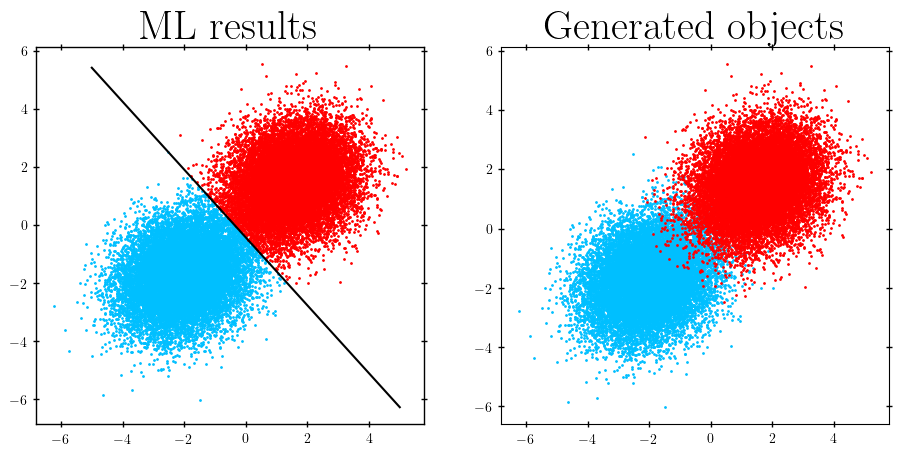

In [45]:
RecognizedX0_1s = np.transpose(ListX0)[0]
RecognizedX0_2s = np.transpose(ListX0)[1]
RecognizedX1_1s = np.transpose(ListX1)[0]
RecognizedX1_2s = np.transpose(ListX1)[1]

# plot and compare with the data basing on which the ML was trained

plt.figure(figsize=(11, 5), dpi=100)


ax1=plt.subplot(121)
plt.setp(ax1.spines.values(), linewidth=1)
ax1.tick_params(direction='inout',axis="both",top="False",right="False",width=1,length=5)
#fig = mpl.pyplot.gcf()
#fig.set_size_inches(17, 7)


r1=plt.scatter(RecognizedX0_1s, RecognizedX0_2s, s=1,c="deepskyblue")
r2=plt.scatter(RecognizedX1_1s, RecognizedX1_2s, s=1,c="red")
r22=plt.plot(x1s, x2s, c="black")

plt.title("ML results",size=30)

ax2=plt.subplot(122)
plt.setp(ax1.spines.values(), linewidth=1)
ax2.tick_params(direction='inout',axis="both",top="False",right="False",width=1,length=5)

r3=plt.scatter(X0_1s,X0_2s,s=1,c="deepskyblue")
r4=plt.scatter(X1_1s,X1_2s,s=1,c="red")

plt.title(r"Generated objects",size=30);

### Logistic regression

Now we apply the following sigmoid function:

$g(z)=[1+\mathrm{exp}(-z)]^{-1} $.

Assumme that $h_\theta(x)=g(\theta^T x)$ the distribution of $y$ given $x$ parametrized by $\theta$ is $p(y|x,\theta)=[h_\theta(x)]^y[1-h_\theta(x)]^{1-y}$ where the training examples wwere obtained in independently. Therefore the likelihood of parameters $L(\theta) = \prod_i [h_\theta(^{(i)})]^{y^{(i)}}[1-h_\theta(x^{(i)})]^{1-y^{(i)}}$. For convenience we can maximize $\log[L(\theta)]$ where the corresponding gradien ascent algorithm reads:

$
\theta_j := \theta_j+\alpha \sum_{i=1}^M\left[y^{(i)} - h_\theta(x^{(i)})\right] x^{(i)}_j
$

Here, $y=1$ for $g(z)>0.5$ and $y=0$ for $g(z)<0.5$. The decision boundary is given by the relation $g(z)=0.5 \Longrightarrow z = 0$. In our case we have 2 features $x_1, x_2$ of so let us assume that $x_0=1$ and thus $\theta^T x =\theta_0 x_0+\theta_1 x_1+\theta_2 x_2=\theta_0 +\theta_1 x_1+\theta_2 x_2$. In consequence, the decision boundary is given by the relation $x_2=-\frac{1}{\theta_2}(\theta_0+\theta_1 x_1)$ .

In [53]:
Xwith0 = np.append( np.ones( (len(X),1) ), X, axis=1) # add x0 = 1

def LRThetaDotXs(Thetas):
    ThetaXs = np.einsum('i,ji->j', Thetas, Xwith0)
    return ThetaXs

def LRYminusHArray(ThetaXs):
    Hs = 1./(1+np.exp(-ThetaXs))
    return Y-Hs

def LogLikelihood(ThetaXs):
    Hs = 1./(1+np.exp(-ThetaXs))
    l = np.log( (Hs**Y) * ((1-Hs)**(1-Y)) ) 
    return np.sum(l)

def LRgradient(alpha, NumOfSteps, ThetaVec0):

    ThetaXs0 = LRThetaDotXs(ThetaVec0)
    arr = LRYminusHArray(ThetaXs0)

    for i in range(0, NumOfSteps):
        SumDifX = np.dot( arr, Xwith0 )
        ThetaVec = ThetaVec0 + alpha*SumDifX
        ThetaVec0 = ThetaVec
        
        ThetaXs0 = LRThetaDotXs(ThetaVec0)
        arr = LRYminusHArray(ThetaXs0)
        
        if i%500 == 0:
            print("Likelihood = ", LogLikelihood(ThetaXs0) )
    
    print("\ndecision boundary: x2 = "+str( -ThetaVec0[0]/ThetaVec0[2]) + " - " + str(ThetaVec0[1]/ThetaVec0[0]) +" x1")
    return ThetaVec0

# gradien descent
LRThetaVec0 = [0,0,0] # initialization of thetas
NumOfSteps = 5000
alpha = 0.00005

LRThetas = LRgradient(alpha, NumOfSteps, LRThetaVec0)

Likelihood =  -2178.112120696798
Likelihood =  -1396.3615346981585
Likelihood =  -1396.2613295424017
Likelihood =  -1396.2611442302725
Likelihood =  -1396.2611438719719
Likelihood =  -1396.2611438712777
Likelihood =  -1396.261143871276
Likelihood =  -1396.2611438712765
Likelihood =  -1396.2611438712763
Likelihood =  -1396.2611438712763

decision boundary: x2 = -0.43245055626770007 - 2.7636390629529015 x1


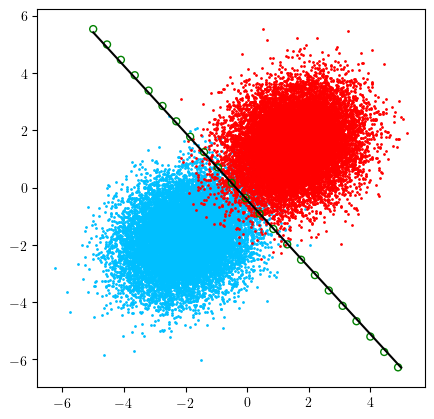

In [54]:
# Compare with GDA decision boundary 
LRX1grad = np.arange(-5,5,0.45)
LRX2grad = -LRThetas[0]/LRThetas[2] - LRThetas[1]/LRThetas[2] * LRX1grad

plt.figure(figsize=(5, 5), dpi=100)

plt.scatter(X0_1s,X0_2s,s=1,c="deepskyblue")
plt.scatter(X1_1s,X1_2s,s=1,c="red")
plt.plot(x1s, x2s, c="black")
plt.scatter(LRX1grad, LRX2grad, facecolors='none', edgecolors='green',s=25);

### The perceptron learning algorithm

We also examine the perceptron learning algorithm where the step function

$g(z)=\left\{ 
\begin{array}{ll} 
1,& z\geq 0 \\   
0, & z<0
\end{array}\right. ,$

is used and employ the same updates

$
\theta_j := \theta_j+\alpha \sum_{i=1}^M\left[y^{(i)} - h_\theta(x^{(i)})\right]x^{(i)}_j
$

Note that in such a case the decision boundary is given by the equation $\theta^T x = 0$. So... again $x_2=-\frac{1}{\theta_2}(\theta_0+\theta_1 x_1)$ 

In [57]:
Xwith0 = np.append( np.ones( (len(X),1) ), X, axis=1) # add x0 = 1

def PYminusHArray(Thetas):
    Hs = np.einsum('i,ji->j', Thetas, Xwith0)
    map_positive = Hs >= 0
    map_negative = Hs <  0
    Hs[ map_positive ] = 1
    Hs[ map_negative ] = 0
    return Y-Hs

# here I calculate the least-squares cost function because mathematically 
# this function should be minimized by the employed algorithm
def CostFunction(YminusH_arr):
    YminusH_arr2 = pow(YminusH_arr,2.)
    return 1./2.*np.sum(YminusH_arr2)

def Pgradient(alpha, NumOfSteps, ThetaVec0):

    arr = PYminusHArray(ThetaVec0)

    for i in range(0, NumOfSteps):
        SumDifX = np.dot( arr, Xwith0 )
        ThetaVec = ThetaVec0 + alpha*SumDifX
        ThetaVec0 = ThetaVec
        arr = PYminusHArray(ThetaVec0)
        if i%100 == 0:
            print("Cost Function = ", CostFunction(arr) )
    
    print("\ndecision boundary: x2 = "+str( -ThetaVec0[0]/ThetaVec0[2]) + " - " + str(ThetaVec0[1]/ThetaVec0[0]) +" x1")
    return ThetaVec0

# gradien descent
ThetaVec0 = [0,0,0] # initialization of thetas
NumOfSteps = 1000
alpha = 0.005

PThetas = Pgradient(alpha, NumOfSteps, ThetaVec0)

Cost Function =  538.5
Cost Function =  257.0
Cost Function =  260.0
Cost Function =  263.5
Cost Function =  260.0
Cost Function =  259.5
Cost Function =  259.5
Cost Function =  260.0
Cost Function =  259.5
Cost Function =  275.5

decision boundary: x2 = -0.447557690903289 - 2.6929784870094777 x1


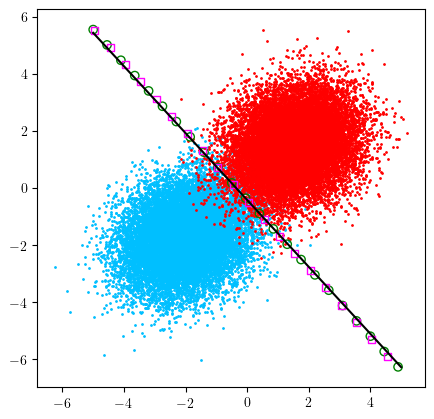

In [60]:
# Compare decision boundaries 
PX1grad = np.arange(-4.95,4.95,0.5)
PX2grad = -PThetas[0]/PThetas[2] - PThetas[1]/PThetas[2] * PX1grad

plt.figure(figsize=(5, 5), dpi=100)

plt.scatter(X0_1s,X0_2s,s=1,c="deepskyblue")
plt.scatter(X1_1s,X1_2s,s=1,c="red")
plt.plot(x1s, x2s, c="black")
plt.scatter(LRX1grad, LRX2grad, facecolors='none', edgecolors='green')
plt.scatter(PX1grad, PX2grad,  marker='s', facecolors='none', edgecolors='magenta',s=25);